# Posterior Predictive Analysis for SV Model

-  Step 1: Simulate hypothetical parameters via from posterior distribution via HMC in Stan

- Step 2: Compute simulated data via the likelihood function, conditional on the simulated parameters (in Stan)

- Step 3: Compare simulated data with observed data to validate model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Current working directory: ", os.getcwd())

Current working directory:  c:\Users\nklatsky\econometrics\econometrics2024\project\code\stochastic_volatility


## Read in Real Data

In [3]:
# Read in the train-test split 
# Read train_test.csv
train_test_split = pd.read_csv("../../train_test.csv")
train_size = train_test_split['train'][0]
test_size = train_test_split['test'][0]

# Define data path:
data_path = "../../data/DXY_approx_percent_returns.csv"
real_data = pd.read_csv(data_path, index_col=0)
real_data = real_data - np.mean(real_data)

# calculate the splitting point as the train_size * len of data, rounded
split_point = int(train_size * len(real_data))

# Take training data range only
real_data = real_data.iloc[:split_point]
real_data


,DXY
Date,
1994-04-01,-0.435009
1994-05-01,0.030122
1994-06-01,0.247245
1994-07-01,-0.768186
1994-10-01,0.362673
...,...
2018-02-21,0.315110
2018-02-22,-0.294709
2018-02-23,0.162735


In [4]:
# calculate summary stats on real data: mean, std, skew, kurtosis, min, max, .025, .50, .975 quantiles
summary_stats = real_data.describe(percentiles=[.025, .5, .975])
summary_stats


,DXY
count,6241.000000
mean,-0.002077
std,0.498790
min,-3.057377
2.5%,-1.026845
50%,-0.000945
97.5%,1.018463
max,2.518960


## Read in Generated Data

In [5]:
# Read in generated data from prior predictive distribution(y_sim_samples)

sv_y_post_path = "sampler_outputs/y_post_samples.csv"
sv_y_post = pd.read_csv(sv_y_post_path)
sv_y_post

,0,1,2,3,4,5,6,7,8,9,...,6231,6232,6233,6234,6235,6236,6237,6238,6239,6240
0,0.909091,0.360467,-0.703670,0.185092,-0.067666,-0.409735,-0.634642,-0.070723,0.041350,1.065020,...,-0.107739,0.055692,-0.044933,0.235921,0.316677,-0.121001,-0.280715,0.086335,0.424413,-0.164274
1,0.476266,-0.488406,-1.144010,-0.070323,-0.814864,-0.027909,0.669641,-0.002535,-0.360981,-0.052846,...,0.429255,0.118504,0.034611,-0.034791,-0.131423,-0.559767,0.709071,0.143593,0.258215,-0.296054
2,1.541750,-0.047356,-0.198072,0.212535,0.233723,0.293294,0.121374,-0.456572,-1.225680,-0.240886,...,-0.107092,-0.135602,0.195079,-0.042196,-0.197246,0.423633,0.404932,-0.038709,-0.097518,-0.007483
3,-0.005548,0.017254,-0.341982,0.458615,-0.027903,0.205978,-0.201036,-0.243012,0.158639,0.326381,...,0.407617,-0.534853,0.507855,-0.814802,-0.254089,-0.634764,0.598034,0.108689,-0.712999,-0.448927
4,-0.031537,-0.276193,-0.573615,0.271942,0.155371,-0.910609,-0.506499,-0.446799,0.730010,-0.346158,...,0.307536,0.013052,0.310091,0.041776,-0.041674,-0.159048,0.146792,0.043839,0.015665,-0.090058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.052137,-0.508991,0.182963,-0.297106,-0.454543,-0.323227,0.420883,0.494125,-0.599032,0.165640,...,0.467552,0.074332,1.142890,0.174308,-0.085699,-0.300128,0.874614,-0.525133,0.625138,-0.507480
3996,0.969414,0.464746,-0.563707,-0.564466,-0.567542,-0.187700,0.157582,0.957244,-0.165611,-1.505200,...,-0.260763,0.371680,-0.944486,-0.136742,0.403689,-0.213821,0.784166,0.186913,0.559455,0.116101
3997,-0.075739,-0.526518,0.167200,0.356254,-0.416677,0.134755,-0.326012,0.468661,-0.324418,0.367753,...,0.028909,-0.527965,0.128546,0.146492,-0.072059,-0.143874,-0.211481,0.002767,0.067919,-0.198307
3998,0.022927,-0.110981,0.487249,0.188062,0.015659,-0.244739,0.307306,0.380960,0.097974,-0.121653,...,0.064360,0.379737,0.073754,0.027174,-0.158248,0.016068,0.127328,-0.005607,-0.363214,-0.167951


# Comparison

Statistics for Index 5:
Real Data Mean:  -0.002077034927474549
Posterior Data Mean:  0.004317410040682582
Real Data StdDev:  DXY    0.49875
dtype: float64
Posterior Data StdDev:  0.4661568075908492
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  0.031299930226845095
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  1.3880699467504392




c:\Users\nklatsky\econometrics\econometrics2024\myenv\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


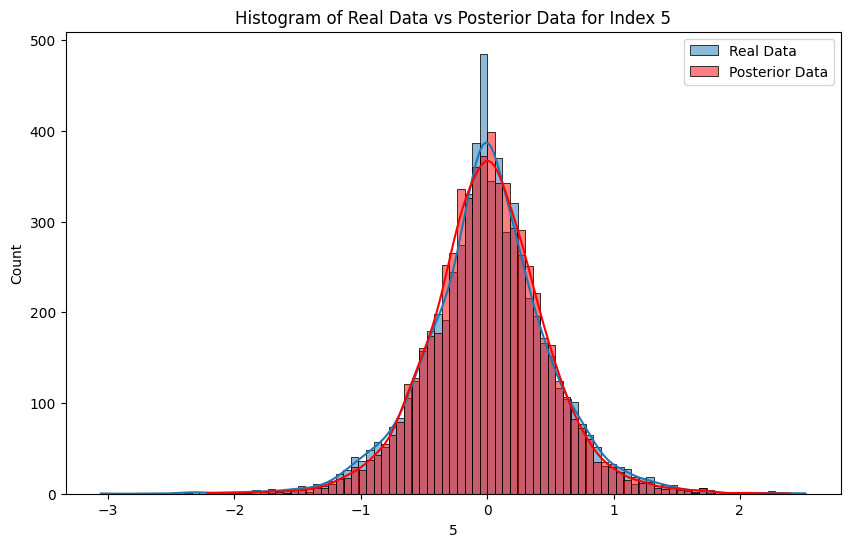

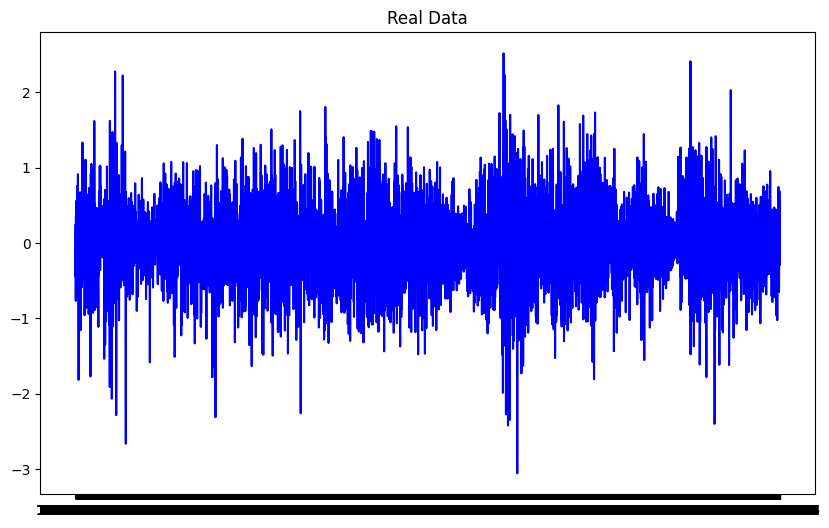

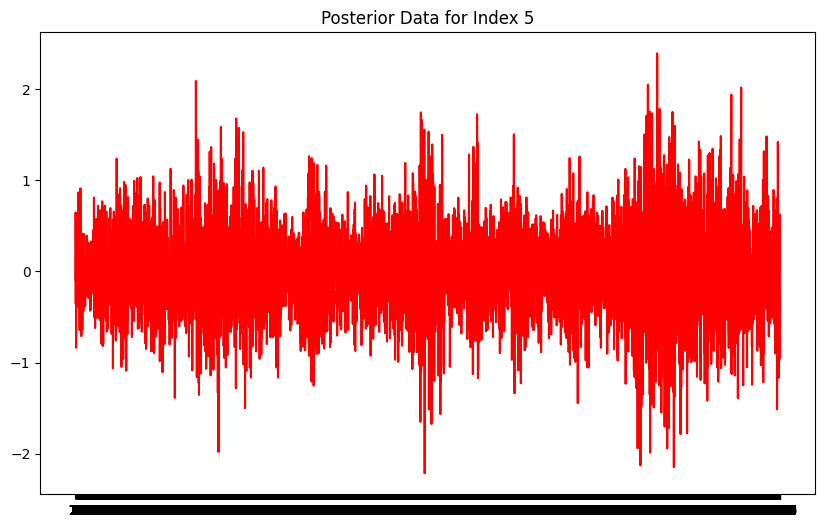

c:\Users\nklatsky\econometrics\econometrics2024\myenv\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Statistics for Index 2000:
Real Data Mean:  -0.002077034927474549
Posterior Data Mean:  -5.500294024996173e-05
Real Data StdDev:  DXY    0.49875
dtype: float64
Posterior Data StdDev:  0.4797587971209179
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  -0.03994224544713863
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  1.0641085081887138




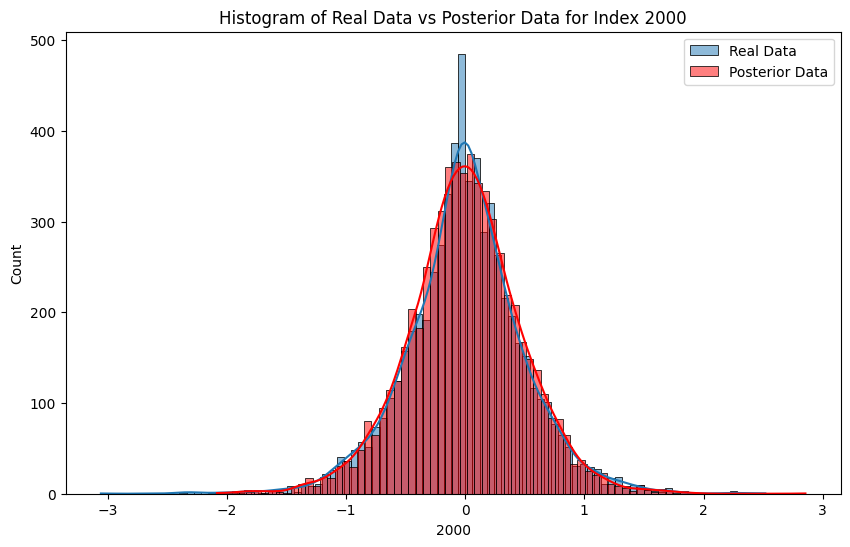

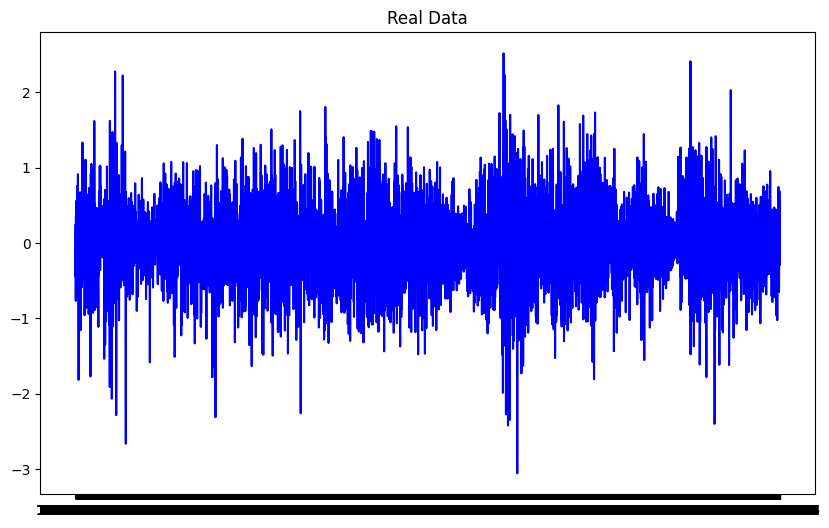

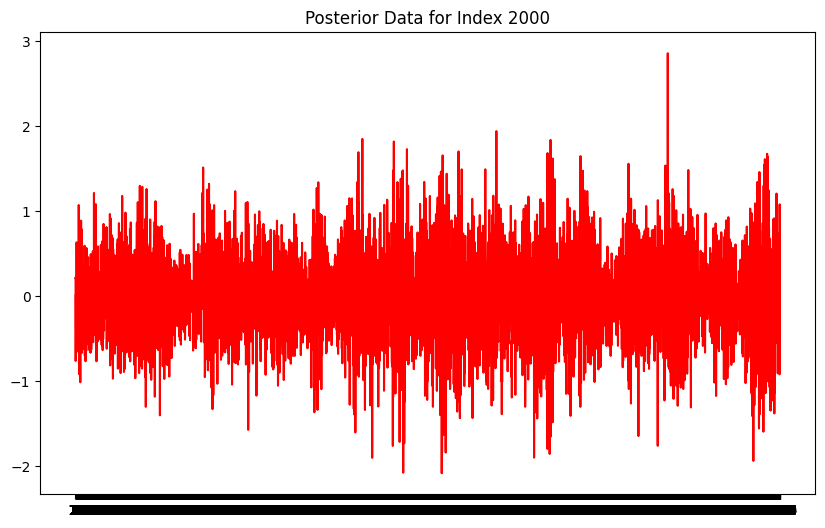

c:\Users\nklatsky\econometrics\econometrics2024\myenv\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Statistics for Index 3000:
Real Data Mean:  -0.002077034927474549
Posterior Data Mean:  0.008877840608348021
Real Data StdDev:  DXY    0.49875
dtype: float64
Posterior Data StdDev:  0.4663917101205902
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  0.0281783755943965
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  1.4683953805674999




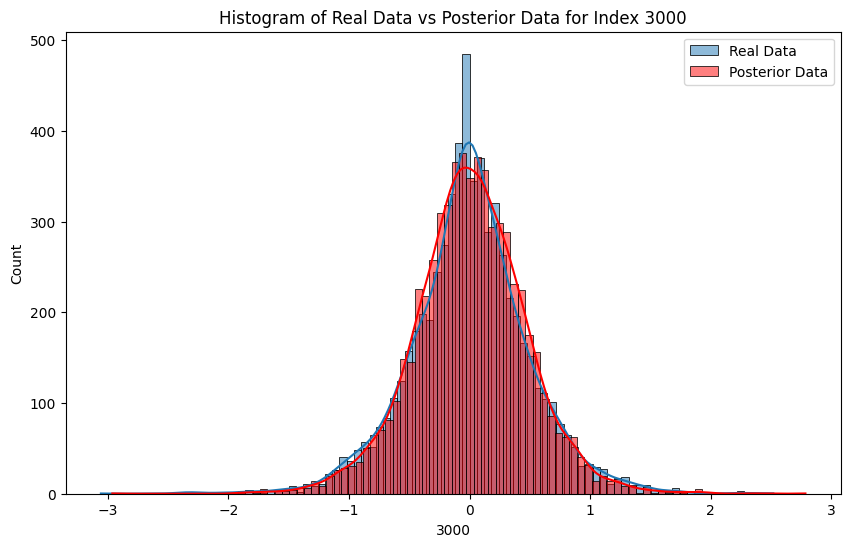

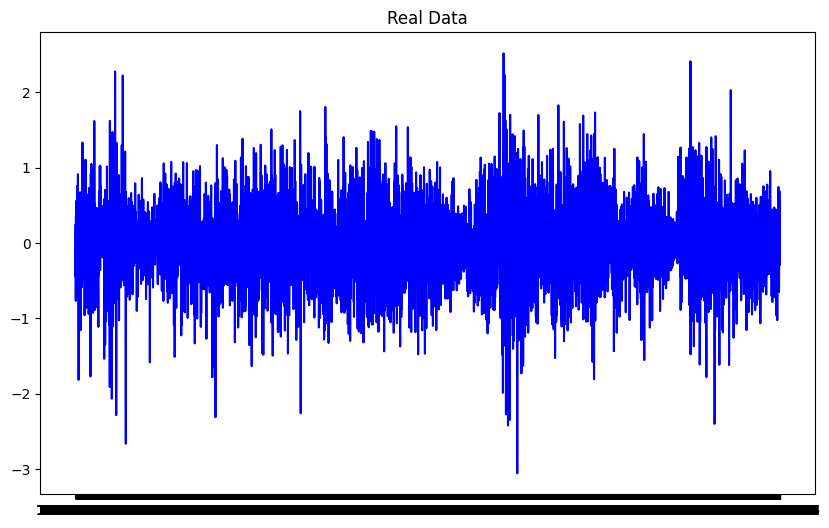

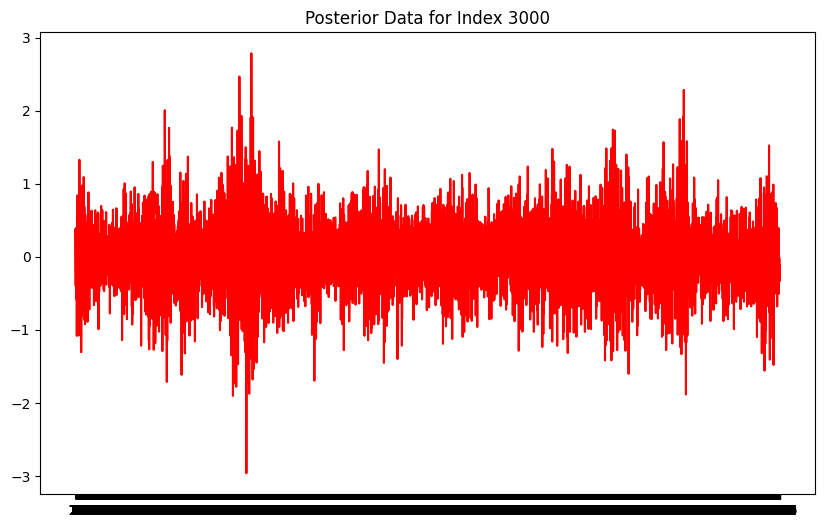

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting indices for detailed comparison, assuming a larger dataset
indices = [5, 2000, 3000]

# Loop through selected indices
for index in indices:
    real_sample = real_data
    post_sample = sv_y_post.iloc[index]

    # Calculate statistics for the current index
    real_mean = np.mean(real_sample)
    real_std = np.std(real_sample)
    real_skew = real_sample.skew()
    real_kurt = real_sample.kurt()

    post_mean = np.mean(post_sample)
    post_std = np.std(post_sample)
    post_skew = post_sample.skew()
    post_kurt = post_sample.kurt()

    # Print statistics
    print(f"Statistics for Index {index}:")
    print("Real Data Mean: ", real_mean)
    print("Posterior Data Mean: ", post_mean)
    print("Real Data StdDev: ", real_std)
    print("Posterior Data StdDev: ", post_std)
    print("Real Data Skewness: ", real_skew)
    print("Posterior Data Skewness: ", post_skew)
    print("Real Data Kurtosis: ", real_kurt)
    print("Posterior Data Kurtosis: ", post_kurt)
    print("\n")

    # Plot histograms for the current index
    plt.figure(figsize=(10, 6))
    sns.histplot(real_sample, kde=True, color='blue', label='Real Data')
    sns.histplot(post_sample, kde=True, color='red', label='Posterior Data')
    plt.title(f"Histogram of Real Data vs Posterior Data for Index {index}")
    plt.legend()
    plt.show()

    # Plot time series for the current index
    plt.figure(figsize=(10, 6))
    plt.plot(real_sample, color='blue', label='Real Data')
    plt.title("Real Data")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(post_sample, color='red', label='Posterior Data')
    plt.title(f"Posterior Data for Index {index}")
    plt.show()
